# EEG Mental State Classification: Eyes Open vs Eyes Closed

# Table of Contents
- [Introduction](#introduction)
- [Data Processing](#data-processing)
- [Machine Learning Pre-processing](#machine-learning-pre-processing)
  - [Baseline Logistic Regression Model](#baseline-logistic-regression-model)
    - [Summary of Logistic Regression Model Results](#summary-of-results-from-the-baseline-logistic-regression-model:)
  - [Random Forest Model](#random-forest-model)
    - [Summary of Random Forest Model Results](#summary-of-results-from-the-random-forest-model:)
  - [Feature Importance Analysis](#feature-importance-analysis)
    - [Interpretation of Feature Importance](#interpretation-of-feature-importance:)
- [Conclusion](#conclusion)
- [References](#references)



# Introduction
EEG (electroencephalography) is a non-invasice method to record neural activity from electrodes placed on the scalp and is widely used in neuroscience research and applied neurotechnology. One well-known EEG patterns is that brain activity changes in a consistent way when a person closes their eyes versus keeps them open, especially in posterior regions of the brain. 
In this project, the goal is to build and evaluate a machine learning pipeline that uses public EEG data to classify eyes open vs. eyes closed neural patterns and interpret which EEG channels contribute most to the predictions.

# Data Processing

#### Data Source

The EEG Eye State dataset was obtained from the UCI Machine Learning Repository, a publicly available academic data source. The dataset contains EEG recordings from 14 scalp electrodes collected during alternating eyes-open and eyes-closed conditions. The original data were provided in ARFF format and loaded into Python using the SciPy library before processing.


In [1]:
#dataset

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.io import arff

#load arff data file
data, meta = arff.loadarff("data/EEG Eye State.arff")

#converting arff file to pandas dataframe
df = pd.DataFrame(data)

df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [2]:
#convering eye detection column data to integers
df = df.applymap(lambda x: int(x) if isinstance(x, (bytes, bytearray)) else x)

df.dtypes


AF3             float64
F7              float64
F3              float64
FC5             float64
T7              float64
P7              float64
O1              float64
O2              float64
P8              float64
T8              float64
FC6             float64
F4              float64
F8              float64
AF4             float64
eyeDetection      int64
dtype: object

The dataset was provided in ARFF format, the eye detection column was loaded as byte strings. I converted those to integers to ensure proper data types before ML modeling.

In [3]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [4]:
#seperating the features (electrode columns) from the target (eye detection column).
X = df.drop(columns=['eyeDetection'])
y = df['eyeDetection']

Is the dataset balanced between eyes open vs eyes closed?

In [5]:
df['eyeDetection'].value_counts()


eyeDetection
0    8257
1    6723
Name: count, dtype: int64

The above results show a reasonably balanced dataset. 

In [6]:
#verifying if there are missing values.
df.isnull().sum().sum()

0

# Machine Learning Pre-processing

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
    X, #df.drop(columns=['eyeDetection'])
    y, #df['eyeDetection']
    test_size=0.2,
    random_state=42,
    stratify=y #The dataset was split into training and test sets using stratified sampling to maintain the same proportion of classes as the original dataset.
)

In [8]:
#Feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) #fit scaler only the training data
X_test_scaled = scaler.transform(X_test)

# Baseline Logistic Regression Model

Test Accuracy:
 0.5844459279038718


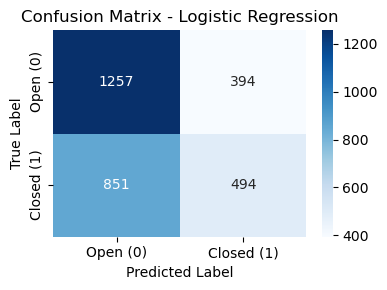


Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.76      0.67      1651
           1       0.56      0.37      0.44      1345

    accuracy                           0.58      2996
   macro avg       0.58      0.56      0.56      2996
weighted avg       0.58      0.58      0.57      2996



In [9]:
#baseline model - logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

#initialize
baseline_model = LogisticRegression(max_iter=1000)

#train
baseline_model.fit(X_train_scaled, y_train)

#test
y_pred = baseline_model.predict(X_test_scaled)

#evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)


#accuracy score
print("Test Accuracy:\n", accuracy)

#visualizing confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Open (0)", "Closed (1)"],
    yticklabels=["Open (0)", "Closed (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

#classification report
print("\nClassification Report:\n", cr)


### Summary of Results from the Baseline Logistic Regression Model:

Logistic Regression was used as a baseline classifier to assess whether EEG features can reliably distinguish between eyes-open and eyes-closed states. Model performance was evaluated using accuracy, precision, recall, and confusion matrix analysis.


The baseline Logistic Regression model achieved an overall accuracy of 58% in distinguishing between eyes-open and eyes-closed EEG states. Examination of the confusion matrix shows that the model correctly identified 1,257 eyes-open cases, but frequently misclassified eyes-closed segments as eyes open, with 851 such errors. This imbalance is reflected in the recall metrics, where the model achieved a recall of 76% for eyes-open states but only 37% for eyes-closed states. These results indicate that the linear model is more effective at detecting eyes-open EEG patterns and has a clear limitation in identifying eyes-closed activity, suggesting that the underlying EEG features may require more expressive, non-linear modeling approaches

# Random Forest Model

Test Accuracy:
 0.9335781041388518


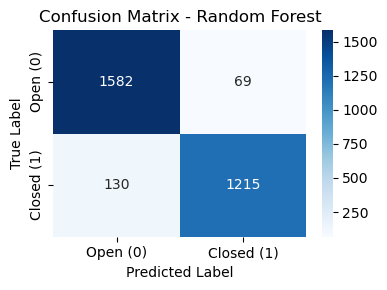


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1651
           1       0.95      0.90      0.92      1345

    accuracy                           0.93      2996
   macro avg       0.94      0.93      0.93      2996
weighted avg       0.93      0.93      0.93      2996



In [10]:
#Random Forest Model

from sklearn.ensemble import RandomForestClassifier

#initialize random forest
rf_model = RandomForestClassifier (
    n_estimators=200,
    random_state=42,
    n_jobs=-1 #use all CPU cores available or faster training.
)


#train
rf_model.fit(X_train, y_train)

#test
y_pred_rf = rf_model.predict(X_test)

#evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_cr = classification_report(y_test, y_pred_rf)

#Accuracy score
print("Test Accuracy:\n", rf_accuracy)

#visualizing confusion matrix
plt.figure(figsize=(4,3))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["Open (0)", "Closed (1)"],
    yticklabels=["Open (0)", "Closed (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()

#Classification report
print("\nClassification Report:\n", rf_cr)





### Summary of Results from the Random Forest Model:
The random forest model achieved a test accuracy of 93% which is a substantial improvement over the logistic regression model. The confusion matrix shows that only 130 eyes-closed EEG segments were misclassified as eyes open, and just 69 eyes-open segments were misclassified as eyes closed. This is reflected by the recall metrics, with a recall of 96% for eyes-open states and 90% for eyes closed states.
Overall the random forest model performed much more effectively when identidying mental states of either eyes-closed or eyes-open from EEG data. This demonstrates that non-linear models, such as Random Forest classifiers, are more robust for capturing complex neural patterns in EEG data.

# Feature Importance Analysis

In [11]:
#feature importance

feature_importance = pd.DataFrame({
    'EEG_Channel': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,EEG_Channel,Importance
6,O1,0.118554
5,P7,0.106159
1,F7,0.091120
12,F8,0.081121
0,AF3,0.078130
13,AF4,0.077829
11,F4,0.061504
10,FC6,0.060465
3,FC5,0.060417
9,T8,0.058096


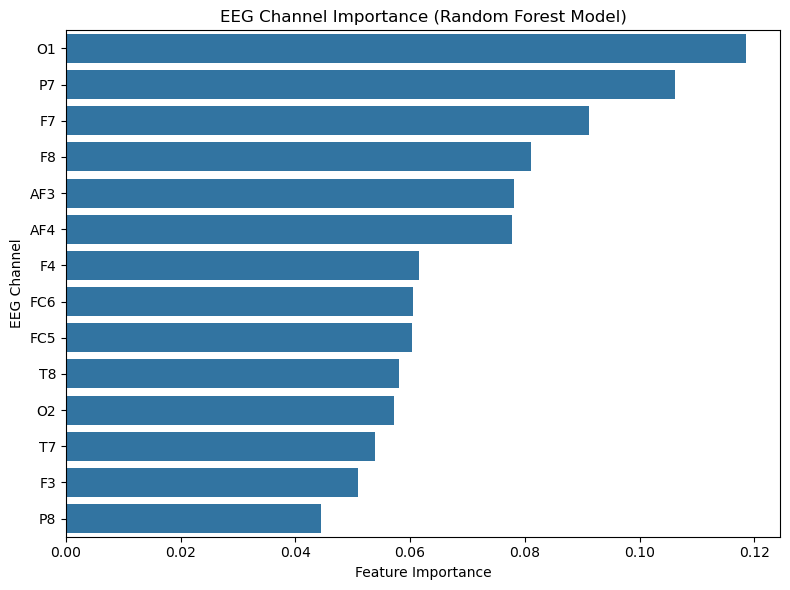

In [12]:
#visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.barplot(
    data=feature_importance,
    x="Importance",
    y="EEG_Channel"
)

plt.title("EEG Channel Importance (Random Forest Model)")
plt.xlabel("Feature Importance")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()

### Interpretation of Feature Importance:

The random forest feature importance analysis showed that the posterior channels (O1 and P7) were among the most influential predictors of eye state. This pattern is consistent with established neuroscience where the posterior regions of the brain are associated with vision and known neural patterns such as the berger effect where alpha activity in the posterior areas increases during eyes closed conditions (1). 
There were also frontal channels that ranked highly in their importance for determining eye states (F7, F8, AF3, AF4). This may suggest wider differences in neural activity between eyes-open vs eyes-closed states. It could also potentially be the signal noise from muscles/eye movements picked up by the frontal electrodes. 

# Conclusion

In this project, a logistic regression model and a random forest model were used to classify EEG eye state (eyes open vs. eyes closed). The logistic regression model performed with a 58% accuracy and struggled to detect eyes-closed (recall = 0.37). The random forest model had a 93% accuracy and a strong recall of 90% for eyes closed detection and 96% for eyes open detection. The feature importance analysis of the random forest model reported that the posterior EEG channels were among the most influential predictors for detecting eyes open vs. eyes closed states. This pattern is consistent with established neuroscience where the posterior regions of the brain are associated with vision

## References:
1. van Dijk, H., Schoffelen, J.-M., Oostenveld, R., & Jensen, O. (2008). Prestimulus oscillatory activity in the alpha band predicts visual discrimination ability. Journal of Neuroscience, 28(8), 1816–1823.
